# Dask

<img src="https://docs.dask.org/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

## Parallelize code with `dask.delayed`

In this notebook we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

We will then go on and take a look at Dask DataFrames and how they compute

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As we'll see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. For now we will just use the default implementation to let the tasks run locally.

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)
z

CPU times: user 3.84 ms, sys: 3.97 ms, total: 7.81 ms
Wall time: 3.02 s


5

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


### Delay, visualize, compute

In [3]:
from dask import delayed
import dask

In [4]:
%%time
# This runs immediately, as it does not compute anything.
# All it does is build a graph.

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.95 ms, sys: 305 µs, total: 2.25 ms
Wall time: 2.74 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [5]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 1.11 ms, sys: 2.24 ms, total: 3.35 ms
Wall time: 2.01 s


5

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [6]:
z

Delayed('add-528c9830-00a2-48fc-bdb7-edf0e2998cd4')

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 47 kB 1.8 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


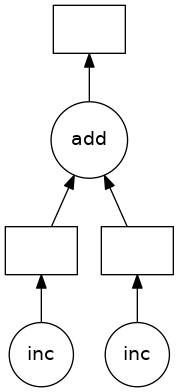

In [8]:
# Look at the task graph for `z`
%pip install graphviz
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

In [9]:
def inc(x):
    #sleep(1)
    return x + 1

def add(x, y):
    #sleep(1)
    return x + y

In [10]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)
x,y,z

CPU times: user 34 µs, sys: 5 µs, total: 39 µs
Wall time: 44.3 µs


(2, 3, 5)

In [11]:
%%time
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)
dask.compute(x,y,z)

CPU times: user 3.07 ms, sys: 31 µs, total: 3.1 ms
Wall time: 2.56 ms


(2, 3, 5)

### Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [12]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [13]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

In [ ]:
total

In [ ]:
%%time
# Your parallel code here...

Solution:

In [ ]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what total is
result = total.compute()
print("After computing :", result)  # After it's computed

How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`?

In [ ]:
total.visualize() # sum function wrapped with delayed

In [ ]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = sum(results)

total.compute()

In [ ]:
total.visualize()

## Dask DataFrames
In this section we use `dask.dataframe` to automatically build similar computations as we just performed, for the common case of tabular computations. Dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers dask.delayed.

In this chapter we use the same airline data as before, but now rather than write for-loops we let dask.dataframe construct our computations for us. The `dask.dataframe.read_csv` function can take a globstring like "data/nycflights/*.csv" and build parallel computations on all of our data at once.

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyse is larger than your machine's RAM. Our dataset does not bring the avaliable memory to its limits, but we can still demonstrate how you go about making use of `dask.dataframe`.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame` API. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Main Take-aways**

1.  Dask DataFrame should be familiar to Pandas users
2.  The partitioning of dataframes is important for efficient execution

### Dask DataFrame Data Model

For the most part, a Dask DataFrame feels like a pandas DataFrame.
So far, the biggest difference we've seen is that Dask operations are lazy; they build up a task graph instead of executing immediately.
This lets Dask do operations in parallel and out of core.

A Dask DataFrame is composed of many pandas DataFrames. For `dask.dataframe` the chunking happens along the index.

<img src="http://docs.dask.org/en/latest/_images/dask-dataframe.svg" width="30%">

We call each chunk a *partition*, and the upper / lower bounds are *divisions*.
Dask *can* store information about the divisions. For now, partitions come up when you write custom functions to apply to Dask DataFrames

### Data Loading

#### Single Files

In [ ]:
import dask.dataframe as dd
import dask

In [ ]:
ddf = dd.read_csv("./data/nycflights/1999.csv") # With Dask, you can also enter a url instead of a directory

In [ ]:
ddf.head(3) # This works just as in pandas

In [ ]:
ddf.tail(3) # And so does this

Watch out for wrongly interpreted data types in Dask! Dask is lazy in every way and you possibly need to manually enter some data types.

In [ ]:
ddf.dtypes

#### Mulitple Files

Dask can intelligently read multiple files into one dataframe with a glob (asterisk):

In [ ]:
filepath = glob("./data/nycflights/*.csv")

In [ ]:
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'))

In [ ]:
ddf.head(3) # this works.

In [ ]:
#ddf.tail(3) # This fails. Why?

In [ ]:
ddf.dtypes # Let's check the datatypes

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of (just) the offending columns. 

In [ ]:
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]}, # Here we parse the year, month and day into date
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

In [ ]:
ddf

In [ ]:
ddf.tail(3) # Now it works

Let's also read the holidays data which will use in the exercises

In [ ]:
holidays = dd.read_parquet(os.path.join('data', "holidays"))

In [ ]:
holidays.head()

### Computations with `dask.dataframe`

We compute the maximum of the `DepDelay` column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

```python
maxes = []
for fn in filenames:
    pdf = pd.read_csv(fn)
    maxes.append(df["DepDelay"].max())
    
final_max = max(maxes)
```

We could wrap that `pd.read_csv` with `dask.delayed` so that it runs in parallel. Regardless, we're still having to think about loops, intermediate results (one per file) and the final reduction (`max` of the intermediate maxes). This is just noise around the real task, which pandas solves with

```python
pdf = pd.read_csv(filename, dtype=dtype)
pdf["DepDelay"].max()
```

`dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel.

Let's compare the performance of data loading and computation to pandas.
First we are going to time this in Dask:

In [ ]:
%%time
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]}, # Here we parse the year, month and day into date
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
ddf["DepDelay"].max().compute()

Let's compare this to pandas:

In [ ]:
%%time
filepath = glob("./data/nycflights/*.csv")
pdf = pd.concat(pd.read_csv(f) for f in filepath)
pdf["DepDelay"].max()

In [ ]:
pdf = pd.concat(pd.read_csv(f) for f in filepath)

In [ ]:
%time pdf["DepDelay"].max()

This writes the delayed computation for us and then runs it.  

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method (notice the parallelism):

In [ ]:
ddf.DepDelay.max().visualize()

### Exercises

In this section we do a few `dask.dataframe` computations. If you are comfortable with pandas then these should be familiar. You will have to think about when to call `compute`.

#### 1.) How many rows are in our dataset?

In [ ]:
# Your code here

Solution:

In [ ]:
len(ddf)

#### 2.) In total, how many non-canceled flights were taken?

With pandas, you would use [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [ ]:
# Your code here

Solution:

In [ ]:
len(ddf[ddf.Cancelled==False])

#### 3.) What was the average departure delay from each airport?
*Hint*: use [`ddf.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

In [ ]:
# Your code here

Solution:

In [ ]:
%time ddf["DepDelay"].groupby(ddf["Origin"]).mean().compute()
# Alternative solution:
# ddf.groupby("Origin").DepDelay.mean().compute()

#### 4.) In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`ddf.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [ ]:
# Your code here

Solution:

In [ ]:
ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()

#### 5.) What day of the week has the worst average departure delay?

In [ ]:
# Your code here

Solution:

In [ ]:
ddf["DepDelay"].groupby(ddf["DayOfWeek"]).mean().compute()

#### 6.) What holiday has the worst average departure delay?

*Hint*: use [`ddf.merge`](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) to bring holiday information.

In [ ]:
# Your code here

Solution:

In [ ]:
%time ddf.merge(holidays, on=["Date"], how="left").groupby("holiday").DepDelay.mean().compute()

# Alternative Solution:
#%%time
#ddf_merged = ddf.merge(holidays, on=["Date"], how="left")
#ddf_merged["DepDelay"].groupby(ddf_merged["holiday"]).mean().compute()

### Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [ ]:
non_cancelled = ddf[~ddf.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [ ]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

But let's try by passing both to a single `compute` call.

In [ ]:
%%time

mean_delay_res, std_delay_res = compute(mean_delay, std_delay)

Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to save the graph to disk so that we can zoom in more easily):

In [ ]:
dask.visualize(mean_delay, std_delay, filename="graph.pdf")

### How does this compare to Pandas?

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then you should use Pandas.  The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

This dataset is small enough that you would normally use Pandas.

We've chosen this size so that exercises finish quickly. Dask.dataframe only really becomes meaningful for problems significantly larger than this, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler allows the same dataframe expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node, and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.

Dask.dataframe operations use `pandas` operations internally. Generally they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task.  This is usually negligible.
2.  When Pandas releases the GIL (global interpreter lock) `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

### Conversion to a timestamp

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [ ]:
crs_dep_time = pdf["CRSDepTime"].head(10)
crs_dep_time

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In the pandas notebook, we rounded and converted the data to integers, then to strings and then to the date_time datatype. However, we could also do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [ ]:
pdf.head(3)

In [ ]:
import pandas as pd
# Rename column "DayofMonth"
pdf.rename(columns = {"DayofMonth":"Day"}, inplace=True)

# Parse to Date:
pdf["Date"] = pd.to_datetime(pdf[["Year","Month","Day"]])

# Get the first 10 dates to complement our `crs_dep_time`
date = pdf.Date.head(10)
date

In [ ]:
# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

#### Custom code and Dask Dataframe

We could swap out `pd.to_timedelta` for `dd.to_timedelta` and do the same operations on the entire dask DataFrame. But let's say that Dask hadn't implemented a `dd.to_timedelta` that works on Dask DataFrames. What would you do then?

`dask.dataframe` provides a few methods to make applying custom functions to Dask DataFrames easier:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timedelta` on our own:

The basic idea is to apply a function that operates on a DataFrame to each partition.
In this case, we'll apply `pd.to_timedelta`.

In [ ]:
hours = ddf.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = ddf.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = ddf.Date + hours_timedelta + minutes_timedelta

In [ ]:
departure_timestamp

In [ ]:
departure_timestamp.head()

#### Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [ ]:
def compute_departure_timestamp(ddf):
    hours = ddf.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = ddf.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return ddf.Date + hours_timedelta + minutes_timedelta

In [ ]:
departure_timestamp = ddf.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

### Limitations

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial shuffling of data, and may write out to disk.

### Learn More


* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

## Dask Array

Parallel, larger-than-memory, n-dimensional array using blocked algorithms.

* Parallel: Uses all of the cores on your computer
* Larger-than-memory: Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
* Blocked Algorithms: Perform large computations by performing many smaller computations.

In [ ]:
import dask.array as da
import numpy as np
import dask

In [ ]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

In [ ]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

In [ ]:
z.compute()

Let's compare Numpy to Dask. First we time the numpy version of a computation:

In [ ]:
%%time 
xn = np.random.normal(10, 0.1, size=(30_000, 30_000)) 
yn = xn.mean(axis=0)
yn

In [ ]:
del xn, yn # Let's release some memory

And now the Dask version:

In [ ]:
xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000))
xd

In [ ]:
xd.nbytes / 1e9  # Gigabytes of the input processed lazily

In [ ]:
yd = xd.mean(axis=0) 
yd

In [ ]:
%%time
xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000))
yd = xd.mean(axis=0) 
yd.compute() 

**Questions to think about:**

* What happens if the Dask chunks=(10000,10000)?
* What happens if the Dask chunks=(30,30)?

### Exercise:

For Dask arrays, compute the mean along axis=1 of the sum of the x array and its transpose.

In [ ]:
# Your code here


**Solution:**

In [ ]:
x_sum = xd + xd.T 
res = x_sum.mean(axis=1)
res.compute()

In [ ]:
del xd, yd # Another memory release

### Persist Data in Memory

If you have the available RAM for your dataset then you can persist data in memory.
This allows future computations to be much faster.

In [ ]:
y = y.persist()

In [ ]:
%time y[0, 0].compute()

In [ ]:
%time y.sum().compute()

As we have seen so far, Dask allows you to simply construct graphs of tasks with dependencies, as well as have graphs created automatically for you using functional, Numpy or Pandas syntax on data collections. None of this would be very useful, if there weren't also a way to execute these graphs, in a parallel and memory-aware way. So far we have been calling `thing.compute()` or `dask.compute(thing)` without worrying what this entails. Now we will discuss the options available for that execution, and in particular, the distributed scheduler, which comes with additional functionality.

Dask comes with four available schedulers:
- "threaded" (aka "threading"): a scheduler backed by a thread pool
- "processes": a scheduler backed by a process pool
- "single-threaded" (aka "sync"): a synchronous scheduler, good for debugging
- distributed: a distributed scheduler for executing graphs on multiple machines, see below.

To select one of these for computation, you can specify at the time of asking for a result, e.g.,
```python
myvalue.compute(scheduler="single-threaded")  # for debugging
```

You can also set a default scheduler either temporarily
```python
with dask.config.set(scheduler='processes'):
    # set temporarily for this block only
    # all compute calls within this block will use the specified scheduler
    myvalue.compute()
    anothervalue.compute()
```

Or globally
```python
# set until further notice
dask.config.set(scheduler='processes')
```

Let's try out a few schedulers on the familiar case of the flights data but first setup up some parameters for the temp-directory & dashboard. 

In [ ]:
import dask
import os

# We should all be using different Ports. Use 480## ##....Trainee ID
DASHBOARD_PORT = 48005
#####

user = os.environ.get("USER")

dask.config.set({'temporary_directory': f'/tmp/dask-{user}'})

dask.config.set({"distributed.dashboard.link": f"/user/{user}/proxy/{DASHBOARD_PORT}/status"})
dask.config.get("distributed.dashboard.link")

In [ ]:
from dask.distributed import Client
client = Client(n_workers=4)

In [ ]:
# Maximum average non-cancelled delay grouped by Airport
largest_delay = ddf[~ddf.Cancelled].groupby("Origin").DepDelay.mean().max()
largest_delay.compute()

In [ ]:
# each of the following gives the same results (you can check!)
# any surprises?
import time
for sch in ['threading', 'processes', 'sync', 'distributed']:
    t0 = time.time()
    r = largest_delay.compute(scheduler=sch)
    t1 = time.time()
    print(f"{sch:>10}, {t1 - t0:0.4f} s; result: {r:0.2f} hours")

### Some Points to Consider:

The `threaded` scheduler is a fine choice for working with large datasets out-of-core on a single machine, as long as the functions being used release the [GIL](https://wiki.python.org/moin/GlobalInterpreterLock) most of the time. NumPy and pandas release the GIL in most places, so the `threaded` scheduler is the default for `dask.array` and `dask.dataframe`. The distributed scheduler, perhaps with `processes=False`, will also work well for these workloads on a single machine.

For workloads that do hold the GIL, as is common with `dask.bag`(not part of this course) and custom code wrapped with `dask.delayed`, we recommend using the distributed scheduler, even on a single machine. Generally speaking, it's more intelligent and provides better diagnostics than the `processes` scheduler.

https://docs.dask.org/en/latest/scheduling.html provides some additional details on choosing a scheduler.

For scaling out work across a cluster, the distributed scheduler is required.

### Making a cluster

The `dask.distributed` system is composed of a single centralized scheduler and one or more worker processes. [Deploying](https://docs.dask.org/en/latest/setup.html) a remote Dask cluster involves some additional effort. But doing things locally it just involves creating a `Client` object, which lets you interact with the "cluster" (local threads or processes on your machine). For more information see [here](https://docs.dask.org/en/latest/setup/single-distributed.html). 

Note that `Client()` takes a lot of optional [arguments](https://distributed.dask.org/en/latest/local-cluster.html#api), to configure the number of processes/threads, memory limits and other 

In [ ]:
client.close()

In [ ]:
import dask
import dask.distributed  
import os
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

Now we need to specify the hardware we want for our cluster. Note that the cores and memory are just what you want from one node. Later we will scale that to our requirements. As we would like to get through the SLURM queue as quickly as possible, it makes sense to use fewer cores and memory and and set a shorter walltime for each worker, but then scale the number of workers accordingly.

In [ ]:
cluster = SLURMCluster(queue="skylake_0096", # this is the partition we want to use
                       project="p70824", # this is the project you are allocated to
                       cores=4,          # number of cores one worker should use
                       memory="4GB",     # memory one worker should have avaliable
                       walltime="00:05:00",
                       interface="ib0",  # ib0 is infiniband, the fast network connection
                       scheduler_options={"interface": "ib0",
                                          "dashboard_address": f":{DASHBOARD_PORT}"
                                         },
                       job_extra_directives=['--qos=skylake_0096', '--reservation=training'])
print(cluster.job_script()) # this is turned into a job script

Now we need to setup a client in order to see the dashboard. This also creates the scheduler which directs the workload to the workers.

In [ ]:
client = Client(cluster)

In [ ]:
client

Here we finally scale the dask cluster to the size we require.

In [ ]:
cluster.scale(jobs=8)   # starts slurm jobs with dask workers in them

In [ ]:
!squeue -u $USER # It might take some time for the jobs to become visible.

### Executing with the distributed client
Let's see what our dask cluster can achieve with this computationally challenging calculation. Note that you might have to wait until sufficient workers are running in the queue.

In [ ]:
import dask.array as da

In [ ]:
x = da.random.random((10_000,10_000,10), chunks=(1000,1000,5))
y = da.random.random((10_000,10_000,10), chunks=(1000,1000,5))
z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1,))

In [ ]:
%%time
z.compute()

In [ ]:
z.dask.visualize() # High level graph. Low level graph with z.visualize(), but this would be overwhelming

Let's try the maximum delay computation from earlier:

In [ ]:
%%time
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]}, # Here we parse the year, month and day into date
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
ddf["DepDelay"].max().compute()

Consider some trivial calculation, such as we've used before, where we have added sleep statements in order to simulate real work being done.

In [ ]:
from dask import delayed
import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

By default, creating a `Client` makes it the default scheduler. Any calls to `.compute` will use the cluster your `client` is attached to, unless you specify otherwise, as above.


In [ ]:
%%time
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)
total.compute()

Let's return to the flights computation from before, and see what happens on the dashboard (you may wish to have both the notebook and dashboard side-by-side). How did does this perform compared to before?

In [ ]:
%time largest_delay.compute()

In this particular case, this should be as fast or faster than the best case, threading, above. Why do you suppose this is? You should start your reading [here](https://distributed.dask.org/en/latest/index.html#architecture), and in particular note that the distributed scheduler was a complete rewrite with more intelligence around sharing of intermediate results and which tasks run on which worker. This will result in better performance in *some* cases, but still larger latency and overhead compared to the threaded scheduler, so there will be rare cases where it performs worse. Fortunately, the dashboard now gives us a lot more [diagnostic information](https://distributed.dask.org/en/latest/diagnosing-performance.html).

If all you want to do is execute computations created using delayed, or run calculations based on the higher-level data collections, then that is about all you need to know to scale your work up to cluster scale. However, there is more detail to know about the distributed scheduler that will help with efficient usage.

### Exercise

Run the following computations while looking at the diagnostics page. In each case what is taking the most time?

In [ ]:
cluster.close()

In [ ]:
cluster = SLURMCluster(queue="skylake_0096", # this is the partition we want to use
                       project="p70824", # this is the project you are allocated to
                       cores=4,          # number of cores one worker should use
                       memory="4GB",     # memory one worker should have avaliable
                       walltime="00:05:00",
                       interface="ib0",  # ib0 is infiniband, the fast network connection
                       scheduler_options={"interface": "ib0",
                                          "dashboard_address": f":{DASHBOARD_PORT}"
                                         },
                       job_extra_directives=['--qos=skylake_0096', '--reservation=training'])
print(cluster.job_script()) # this is turned into a job script

In [ ]:
client = Client(cluster)

In [ ]:
cluster.scale(jobs=4)

In [ ]:
# Number of flights
a = len(ddf)
a

In [ ]:
# Number of non-cancelled flights
b = len(ddf[~ddf.Cancelled])
b

In [ ]:
# Number of non-cancelled flights per-airport
c = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
c

In [ ]:
# Average departure delay from each airport?
d = ddf[~ddf.Cancelled].groupby("Origin").DepDelay.mean().compute()
d

In [ ]:
# Average departure delay per day-of-week
e = ddf.groupby(ddf.Date.dt.dayofweek).DepDelay.mean().compute()
e

In [ ]:
cluster.close()
client.shutdown()

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(False)